In [1]:
# Import Libraries
import numpy as np

from project_utils.bb_model         import BB_Model
from project_utils.feature_stats    import Feature_Statistics
from project_utils.feature_stats    import Regression_Container
from project_utils.acq_data_capture import Acq_Data_nD
from project_utils.surroagte_gp     import Surrogate_GP



In [2]:
Num_Points = 5
Title      = 'Synthetic Regression'
FUR_Weight = 0.1

In [3]:
if isinstance(FUR_Weight, float):
    FUR_Weight = [FUR_Weight, 1.0 - FUR_Weight]
    
print(FUR_Weight)

[0.1, 0.9]


In [4]:
# Load Forrester model

Reg_Data = BB_Model(dataset = 'Synthetic_Reg', Feature_Counts=[16,12])

#Reg_Data.df().head()

In [5]:
Reg_Data.MPL()

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


0.26282700412836824


MLPRegressor(random_state=RandomState(MT19937) at 0x196FF0C9840)

In [6]:
Reg_Data.Random_Forest()

0.3621523884958232


RandomForestRegressor(random_state=RandomState(MT19937) at 0x196FF0C9840)

In [7]:
Reg_Data.GP()

-1.7127278795149703


GaussianProcessRegressor()

In [8]:
Reg_Data.L_Regression()

0.4981346220028543


LinearRegression()

In [9]:
print(Reg_Data.get_features())

['Passive_0', 'Passive_1', 'Active_2', 'Active_3', 'Active_4', 'Active_5', 'Active_6', 'Active_7']


In [10]:
#Default settings
from unravel_2.ur_model import UR_Model

X_train, X_test, y_train, y_test = Reg_Data.get_TT_data()

#Initializing the explainer object
URM_Exp = UR_Model(bbox_model           = Reg_Data.get_Random_Forest(),
                   train_data           = X_train,
                   feature_names        = Reg_Data.get_features(),
                   categorical_features = Reg_Data.get_catagorical(),
                   mode                 = Reg_Data.get_mode(),
                   sampling_optimize    = "opt")

#sur_GP = Surrogate_GP()


In [11]:
#I2nd explainer object
URM_Exp_2 = UR_Model(bbox_model           = Reg_Data.get_L_Regression(),
                     train_data           = X_train,
                     feature_names        = Reg_Data.get_features(),
                     categorical_features = Reg_Data.get_catagorical(),
                     mode                 = Reg_Data.get_mode(),
                     sampling_optimize    = "opt")



In [12]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
print('Mean 0:', mean)
print('Std 0: ', std)


Mean 0: [ 12.99504707   7.58183566  16.51169968  18.02354758   9.29200234
  10.9894538  -10.92628618  16.26822872]
Std 0:  [5.36561368 2.13380821 2.07471186 3.69481608 1.53788719 3.37697611
 2.77415241 5.03405368]


In [13]:
# Generate explantion data for Random Forest

Reg_Stats   = Feature_Statistics(feature_names = Reg_Data.get_features(), mode = Reg_Data.get_mode())

Reg_Stats_2 = Feature_Statistics(feature_names = Reg_Data.get_features(), mode = Reg_Data.get_mode())

if Num_Points > X_test.shape[0]: Num_Points = X_test.shape[0]

elif Num_Points == 0:            Num_Points = X_test.shape[0]

for test_instance in range(Num_Points):

    print('INSTANCE: ', test_instance)
       
    data_row  = np.array([X_test[test_instance]])
    
#    data_row  = np.array([0.4])

#    print('data row ',data_row)
    
    URM_Exp.explain(X_init      = data_row.reshape(1, -1),
                    Dimension   = 'Multi D',
                    kernel_type = "Matern",
                    max_iter    = 20,
                    alpha       = "FUR_W",
                    #jitter=5,
                    interval    = 1,
                    weight      = FUR_Weight,
                    normalize   = False)
       
    f_predict = Reg_Data.get_Random_Forest().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    acq_data = URM_Exp.get_acq_data()
    
#    X, y = URM_Exp.get_surrogate_data()

#    e_predict = sur_GP.predict(X, y)
#    e_predict = sur_GP.predict(URM_Exp.get_surrogate_data())

    print(f_predict, e_predict, acq_data.get_fe_x0())
    
    scores = URM_Exp.permutation_importance()
    
    Reg_Stats.Add_Sample(sample_scores = scores,
                         outcome       = y_test[test_instance],
                         X_row         = data_row.reshape(1, -1),
                         f_prediction  = f_predict,
                         e_prediction  = e_predict.ravel(),
                         feopt         = acq_data.get_fe_x0(),
                         model         = URM_Exp.get_exp_model())
    
    
    ############################################################################################
    
    URM_Exp_2.explain(X_init      = data_row.reshape(1, -1),
                      Dimension   = 'Multi D',
                      kernel_type = "Matern",
                      max_iter    = 20,
                      alpha       = "FUR_W",
                      #jitter=5,
                      interval    = 1,
                      weight      = FUR_Weight,
                      normalize   = False)
       
    f_predict = Reg_Data.get_L_Regression().predict(data_row.reshape(1, -1))

    e_predict = URM_Exp_2.exp_predict(data_row.reshape(1, -1))
    e_predict = np.array(e_predict).ravel()
    
    scores = URM_Exp_2.permutation_importance()
    
    Reg_Stats_2.Add_Sample(sample_scores = scores,
                           outcome       = y_test[test_instance],
                           X_row         = data_row.reshape(1, -1),
                           f_prediction  = f_predict,
                           e_prediction  = e_predict.ravel(),
                           feopt         = None,
                           model         = URM_Exp.get_exp_model())
    


INSTANCE:  0
[-55.65330887] [-5.56533089e+01  1.00000004e-05] [-55.6533089]


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  1
[-94.32958631] [-9.43295863e+01  1.00000004e-05] [-94.3295863]
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  2
[-126.74580856] [-1.26745809e+02  1.00000004e-05] [-126.74580855]


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


INSTANCE:  3
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH
[-136.26475698] [-1.36264757e+02  1.00000004e-05] [-136.26475694]
INSTANCE:  4
[-46.11112329] [-4.61111233e+01  1.00000004e-05] [-46.11112329]
Opt iteration fail:  ABNORMAL_TERMINATION_IN_LNSRCH


C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


In [14]:
import matplotlib.pyplot as plt


In [15]:
print(f_predict)
print(e_predict)


[-47.29191617]
[-4.72919162e+01  9.83526872e-06]


In [16]:
Reg_Stats.Feature_Counts(max_features=20, scaled=True, threshold=0.05)


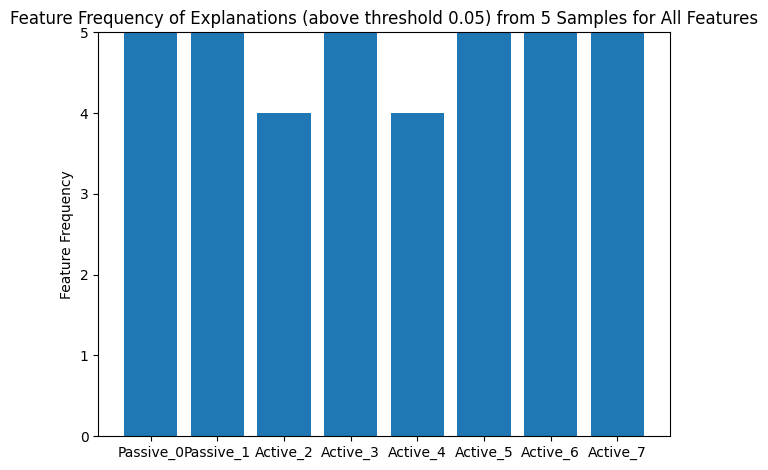

In [17]:
Reg_Stats.Frequency_Plot()


In [18]:
Reg_Stats.Fidelity()

Average, Var, and Max Differences:
y - BB(x):           59.102993929852275  :  1169.2194921679943  :  109.53983182021364
y - exp(x):          59.10299392921276  :  1169.2194924331839  :  109.53983181831966
BB(x) - exp(x):      1.5692870647399106e-08  :  1.8935696999749538e-16  :  3.508975510158052e-08
Average exp(x) var:  1.0000000413701846e-05


In [19]:
Reg_Stats.Jaccard_Values()

Mean Jaccard Similarity:  1.0
Mean Jaccard Distance:    0.0


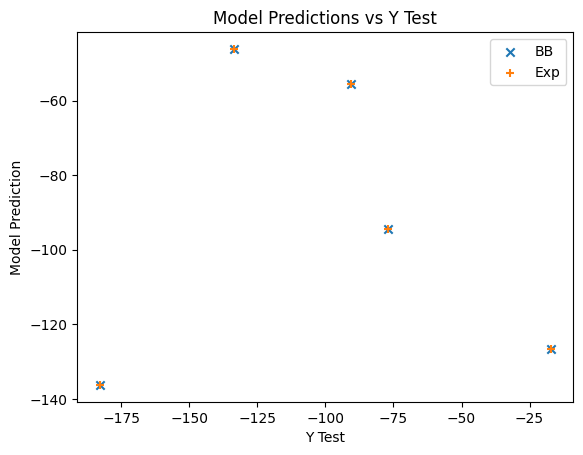

In [20]:
Reg_Stats.Reg_Fidelity_Graph()

top_features True
top_features (5, 8)


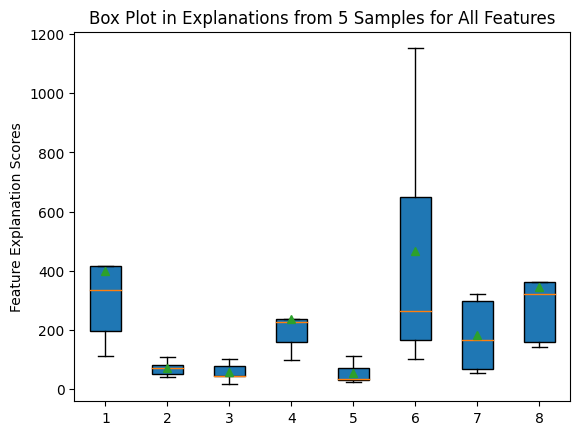

1 -      Passive_0
2 -      Passive_1
3 -      Active_2
4 -      Active_3
5 -      Active_4
6 -      Active_5
7 -      Active_6
8 -      Active_7


In [21]:
Reg_Stats.Box_Plot()


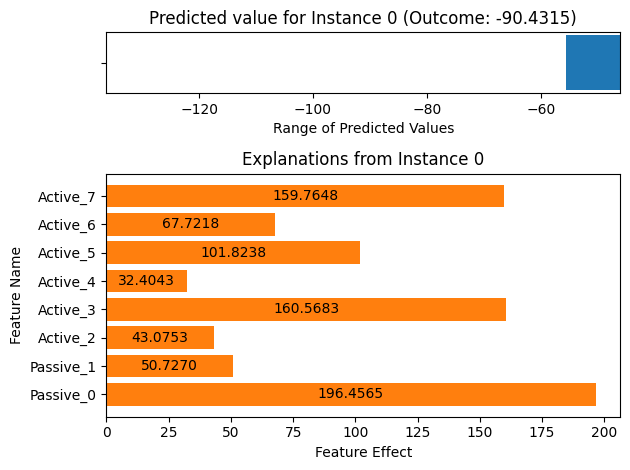

In [22]:
Reg_Stats.View_Explanation(instance = 0)

In [23]:
scores = URM_Exp.permutation_importance()
    
print(scores)

[112.48361947  21.55283581  18.33176435  80.25795566  15.40999274
 123.19220119  73.75704603 113.62996242]


In [24]:
scores_k = URM_Exp.KL_imp()

print(scores_k)

[3.43991544 3.27906899 3.58158274 4.25490554 3.63274535 5.02782976
 3.9735626  3.84119819]


In [25]:
scores_v = URM_Exp.Var_imp()

print(scores_v)

[ 5.13068422  4.30369987  7.20013136 12.40680837  6.95283438 20.21203297
 16.04860642  6.04806477]


In [26]:
scores_d1 = URM_Exp.del_1_rel()

print(scores_d1)

[1.39792441 0.17401691 1.37096004 1.49768223 0.85085237 1.40422731
 1.27128956 0.03304717]


In [27]:
scores_d2 = URM_Exp.del_2_rel()

print(scores_d2)

C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\deneb\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\gaussian_process\_gpr.py:616: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


[1.11781030e-05 3.59719449e-07 7.99996444e+00 9.35127807e-07
 7.78832627e-06 3.38281194e-06 6.66233785e-06 5.25692434e-06]


In [28]:
lin_scores = URM_Exp.Lin_scores()

print(lin_scores)

[-1.86942136  1.29576773 -0.48464385 -5.01725076  0.30133179  5.24696327
  0.04856986  3.81129443]


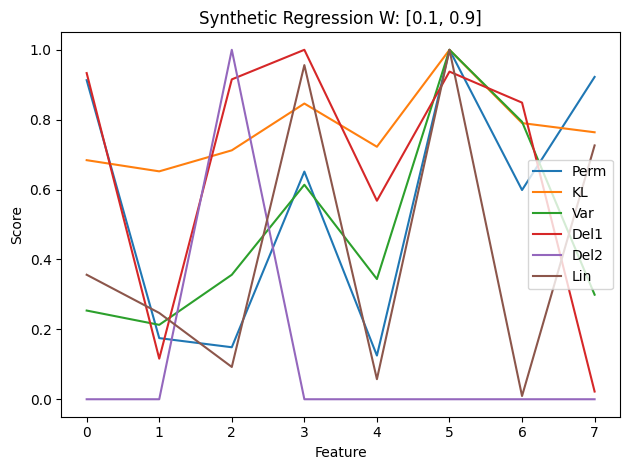

In [29]:
URM_Exp.plot_scores(Title, FUR_Weight)

In [30]:
print(URM_Exp.get_exp_L())


[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 7.91002169e-02  9.96866669e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.07734883e-01  1.78832561e-01  7.73742352e-01  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.0

In [31]:
acq_data.Create_BB_plot()

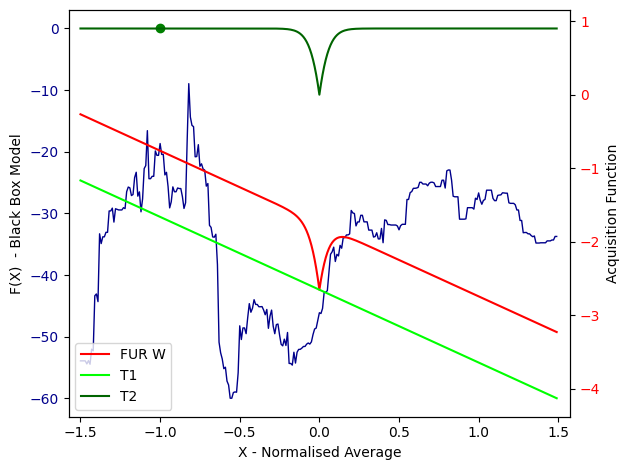

In [32]:
acq_data.plot_point(0)

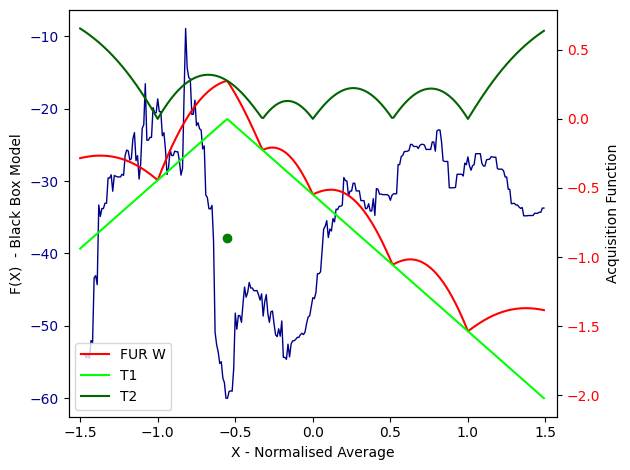

In [33]:
acq_data.plot_point(5)

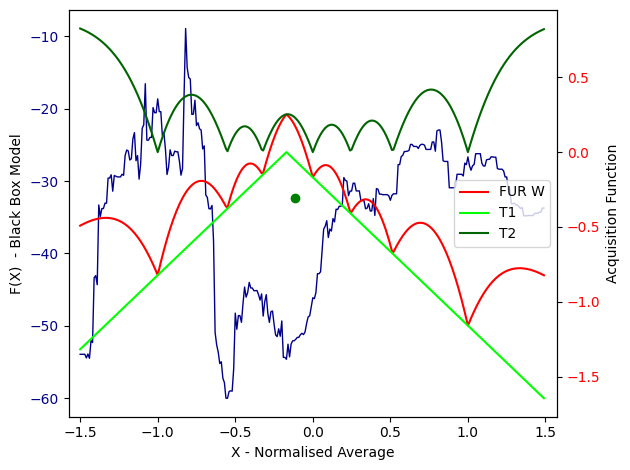

In [34]:
acq_data.plot_point(10)

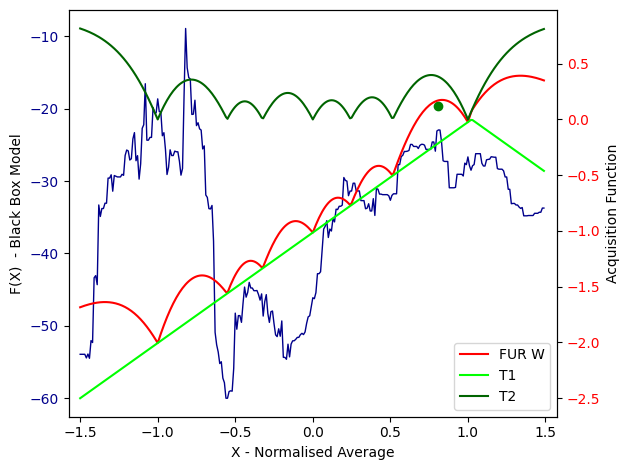

In [35]:
acq_data.plot_point(15)

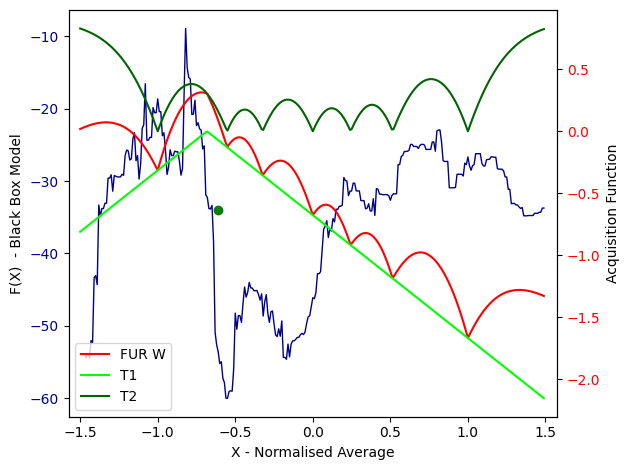

In [36]:
acq_data.plot_point(19)

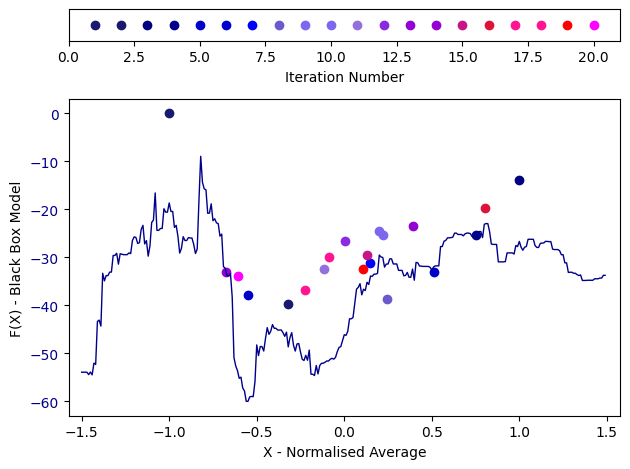

In [37]:
acq_data.plot_all()

In [38]:
#acq_data.plot_t1_t2(0)

In [39]:
#acq_data.plot_t1_t2(1)

In [40]:
#acq_data.plot_t1_t2(2)

In [41]:
#acq_data.plot_t1_t2(3)

In [42]:
#acq_data.plot_t1_t2(4)

In [43]:
#acq_data.plot_t1_t2(5)

In [44]:
#acq_data.plot_t1_t2(6)

In [45]:
#acq_data.plot_t1_t2(7)

In [46]:
#acq_data.plot_t1_t2(8)

In [47]:
#acq_data.plot_t1_t2(9)

In [48]:
#acq_data.plot_t1_t2(10)

In [49]:
#acq_data.plot_t1_t2(11)

In [50]:
#acq_data.plot_t1_t2(12)

In [51]:
#acq_data.plot_t1_t2(13)

In [52]:
#acq_data.plot_t1_t2(14)

In [53]:
#acq_data.plot_t1_t2(15)

In [54]:
#acq_data.plot_t1_t2(16)

In [55]:
#acq_data.plot_t1_t2(17)

In [56]:
#acq_data.plot_t1_t2(18)

In [57]:
#acq_data.plot_t1_t2(19)

In [58]:
Reg_Stats.Fidelity()

print('Fidelity: ', Reg_Stats.fidelity)

Average, Var, and Max Differences:
y - BB(x):           59.102993929852275  :  1169.2194921679943  :  109.53983182021364
y - exp(x):          59.10299392921276  :  1169.2194924331839  :  109.53983181831966
BB(x) - exp(x):      1.5692870647399106e-08  :  1.8935696999749538e-16  :  3.508975510158052e-08
Average exp(x) var:  1.0000000413701846e-05
Fidelity:  0.5896448778434698


In [59]:
Reg_Stats.Jaccard_Values(top_k=4)

print('Jaccard: ', Reg_Stats.jaccard_similarities)

Mean Jaccard Similarity:  0.8400000000000001
Mean Jaccard Distance:    0.16
Jaccard:  0.8400000000000001


In [60]:
Reg_Stats.add_Feature_Coeffs(Feature_Coeffs = Reg_Data.get_Feature_Coeffs())
        
print('Coeff Ratio: ', Reg_Stats.coeffs_ratio)

Mean Scores:  [398.66333141  69.91323551  56.44240153 237.02997017  53.97428234
 466.26380551 181.58355254 346.3859724 ]
Mean Coeffs:  [ 0.          0.          4.80523462 -7.94480593 -4.10839215  9.92095341
  5.90768389 -2.02525044]
Coeff Ratio:  [ 0.          0.          0.08513519 -0.03351815 -0.07611759  0.02127755
  0.03253425 -0.0058468 ]


In [61]:
delete_1_var = Reg_Stats.delete_one()

print('Delete 1 Variance: ', delete_1_var)

Delete 1 Variance:  [5.68801691e-63 1.17005188e-77 1.89452525e-79 4.73099633e-68
 1.63545755e-79 1.60080851e-65 2.02627350e-75 6.54210774e-68]


XDIFF [196.45649353  50.72698024  43.07534612 160.56827827  32.40426711
 101.8238246   67.72180723 159.76483493] [ 47.00305426  34.52710376  27.21296698  91.66563081  14.92346924
 -95.56458316   5.29029696  41.8431418 ]
XDIFF [196.45649353  50.72698024  43.07534612 160.56827827  32.40426711
 101.8238246   67.72180723 159.76483493] [121.72977389  42.627042    35.14415655 126.11695454  23.66386817
   3.12962072  36.5060521  100.80398836]
XDIFF [196.45649353  50.72698024  43.07534612 160.56827827  32.40426711
 101.8238246   67.72180723 159.76483493] [196.45649353  50.72698024  43.07534612 160.56827827  32.40426711
 101.8238246   67.72180723 159.76483493]
XDIFF [196.45649353  50.72698024  43.07534612 160.56827827  32.40426711
 101.8238246   67.72180723 159.76483493] [271.18321316  58.82691847  51.0065357  195.019602    41.14466605
 200.51802848  98.93756236 218.72568149]
XDIFF [196.45649353  50.72698024  43.07534612 160.56827827  32.40426711
 101.8238246   67.72180723 159.76483493] [345.90

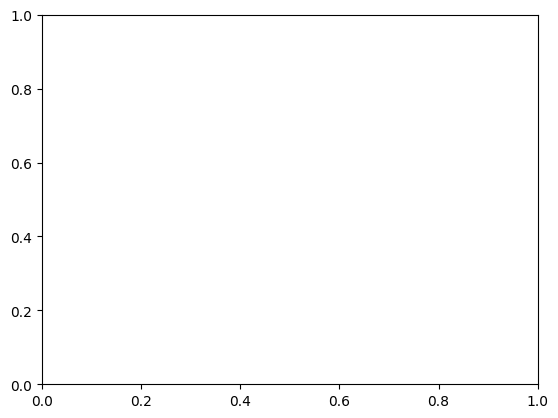

<class 'AttributeError'>: 'Feature_Statistics' object has no attribute 'p_means_mean'

In [62]:
Reg_Stats.Consistancy(plot=True, title = Title)

In [ ]:
Reg_Stats.Compare_Models (model_b = Reg_Stats_2)